In [1]:
import sys
sys.path.append("/home/luca/Desktop/CM/CM/")
sys.path.append("../../")

import numpy as np
from Network import NR, NC
import src.utils as utils
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier


def plot_stats(conf, dataset, test, net, save=False, log=True, time=False, score=False):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    if time:
        net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    if score:
        net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
        if time:
            net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())


def plot_comparison(x_datas, y_datas, x_label, y_label, title, loc='best', yscale='log'):
    plt.plot(x_datas[0], y_datas[0], linewidth=2., label='(A1/cm)')
    plt.yscale(yscale)
    plt.grid(True, 'major', 'both', linewidth=0.3)

    plt.plot(x_datas[1], y_datas[1], linewidth=2., label='(A1/nag)')
    plt.yscale(yscale)

    plt.plot(x_datas[2], y_datas[2], linewidth=2., label='(A2)')
    plt.yscale(yscale)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=loc, fontsize=13)
    plt.title(title)
    plt.show()
    plt.clf()
    

def report_plots(params, dataset, net_SGD, net_SGD_nest, net_Adam, score=False, time=False):

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'
    curve_type = 'Objective function' if not score else 'Score'
    title = curve_type + ' comparison - ' + dataset

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_Adam = net_Adam.train_scores if score else net_Adam.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_Adam_time = net_Adam.epochs_time
    x_Adam_ep = list(range(len(train_res_Adam)))

    if time:
        plot_comparison([x_SGD_time, x_SGD_nest_time, x_Adam_time], 
                      [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                      x_label_time, 
                      curve_type, 
                      title
                     )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_ep, 
                  curve_type, 
                  title
                 )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_Adam.grad_est_per_epoch],
                  x_label_ep, 
                  'Gradient norm', 
                  f'Gradient norm comparison - {dataset}',
                  1
                 )

def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC


    # --- MODEL CONFIGURATIONS ---
    param_SGD = params[dataset]['sgd'].copy()
    param_SGD_nest = params[dataset]['sgd'].copy()
    param_Adam = params[dataset]['adam'].copy()
    
    param_SGD['verbose'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['verbose'] = debug
    param_SGD_nest['nesterovs_momentum'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_Adam['verbose'] = debug
    net_Adam = nn(**param_Adam)   
    # --- MODEL CONFIGURATIONS --- 

    # Train and print best results with given configurations
    net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))
    net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

    print("----- SGD -----")
    print(param_SGD)
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(param_SGD_nest)
    print(net_SGD_nest.best_score(),"\n")

    print("----- Adam -----")
    print(param_Adam)
    print(net_Adam.best_score(),"\n")

    return net_SGD, net_SGD_nest, net_Adam


def report_gap_rate(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    solver = '(A1/cm)'
    plot_name = f"{dataset}_{solver}"
    net_SGD.plot_gap(dataset, solver, save=save)
    net_SGD.plot_rate(plot_name, save=save)

    solver = '(A1/nag)'
    plot_name = f"{dataset}_{solver}"
    net_SGD_nest.plot_gap(dataset, solver, save=save)
    net_SGD_nest.plot_rate(plot_name, save=save)

    solver = '(A2)'
    plot_name = f"{dataset}_{solver}"
    net_Adam.plot_gap(dataset, solver, save=save)
    net_Adam.plot_rate(plot_name, save=save)


def report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    max_epochs = np.max([len(net_SGD.gap), len(net_SGD_nest.gap), len(net_Adam.gap)])
    epochs = range(max_epochs)

    plot_comparison([epochs, epochs, epochs],
        [net_SGD.gap, net_SGD_nest.gap, net_Adam.gap],
        'Epochs',
        'gap term',
        'Objective function gap comparison - ' + dataset)
    
    
def plotData(data, ylabel, title):
    plt.plot(data)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}

params = {
    'cup': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.01,
            'max_iter': 10000,
            'momentum': 0.5,
            'solver': 'sgd',
            'tol': 1e-08
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-08
        }
    },
    'monk1': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'momentum': 0.9,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3,5],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': "adam",
            'tol': 1e-6,
        }
    },
    'monk2': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    },
    'monk3': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    }
}

# Testing configuration

## Monk1

### Configuration

In [4]:
dataset = 'monk1'
epochs = 10000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk1 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])

### Sklearn MLPClassifier

In [21]:
monk1['SGD']['batch_size'] = 10
monk1['SGD_nest']['batch_size'] = 10
monk1['Adam']['batch_size'] = 'auto'
model_SGD = MLPClassifier(**monk1['SGD'], random_state=42, n_iter_no_change=100000)
model_SGD_nest = MLPClassifier(**monk1['SGD_nest'], random_state=42, n_iter_no_change=100000)
model_Adam = MLPClassifier(**monk1['Adam'], random_state=42, n_iter_no_change=100000)

model_SGD.fit(X_train, y_train.ravel())
model_SGD_nest.fit(X_train, y_train.ravel())
model_Adam.fit(X_train, y_train.ravel())

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40000) reached and the optimization hasn't converged yet.
  "Stochastic Optimizer: Maximum iterations (%d) "
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40000) reached and the optimization hasn't converged yet.
  "Stochastic Optimizer: Maximum iterations (%d) "
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40000) reached and the optimization hasn't converged yet.
  "Stochastic Optimizer: Maximum iterations (%d) "


MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=[3, 5],
              max_iter=40000, n_iter_no_change=100000, random_state=42,
              tol=1e-06)

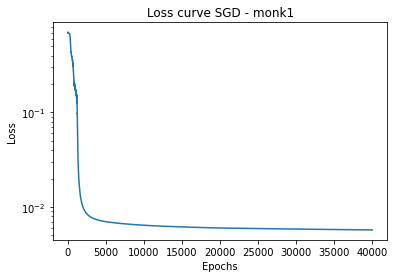

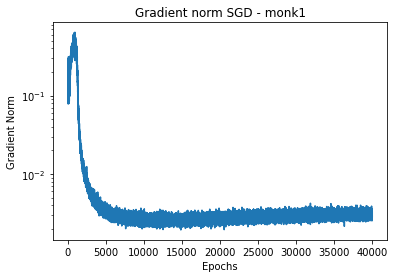

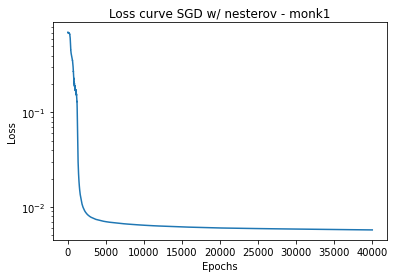

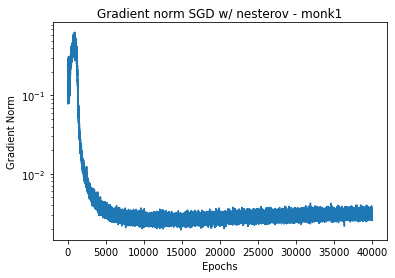

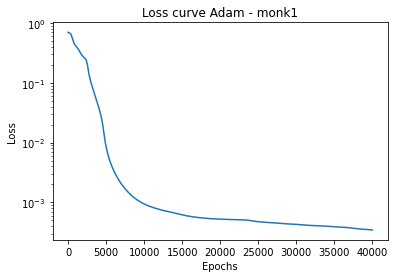

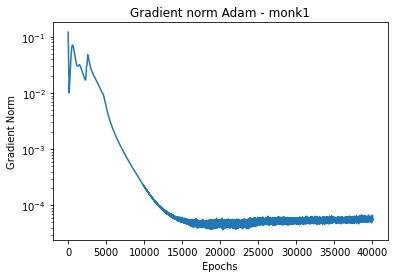

In [23]:
plotData(model_SGD.loss_curve_, 'Loss', 'Loss curve SGD - monk1')
plotData(model_SGD.grad_est, 'Gradient Norm', 'Gradient norm SGD - monk1')

plotData(model_SGD_nest.loss_curve_, 'Loss', 'Loss curve SGD w/ nesterov - monk1')
plotData(model_SGD_nest.grad_est, 'Gradient Norm', 'Gradient norm SGD w/ nesterov - monk1')

plotData(model_Adam.loss_curve_, 'Loss', 'Loss curve Adam - monk1')
plotData(model_Adam.grad_est, 'Gradient Norm', 'Gradient norm Adam - monk1')

### A1 / A2

In [5]:
nn = NC
monk1['SGD']['batch_size'] = None if monk1['SGD']['batch_size'] == 'auto' else monk1['SGD']['batch_size']
monk1['SGD_nest']['batch_size'] = None if monk1['SGD_nest']['batch_size'] == 'auto' else monk1['SGD_nest']['batch_size']
monk1['Adam']['batch_size'] = None if monk1['Adam']['batch_size'] == 'auto' else monk1['Adam']['batch_size']

net_Adam = nn(**monk1['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD = nn(**monk1['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk1['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:24<00:00, 410.61it/s]


NC(alpha=0.001, batch_size=10, hidden_layer_sizes=[3, 5],
   learning_rate_init=0.005, max_iter=10000, momentum=0.9,
   nesterovs_momentum=True, tol=1e-06)

#### Save and load models

In [8]:
# Saving models
save_param = f"{epochs}_upnorm"
net_Adam.saveModel(f"net_Adam_{save_param}")
net_SGD.saveModel(f"net_SGD_{save_param}")
net_SGD_nest.saveModel(f"net_SGD_nest_{save_param}")

In [9]:
# Loading models
nn = NC
net_SGD = nn(**monk1['SGD'])
net_SGD = net_SGD.loadModel('net_SGD')

#### Execution stats

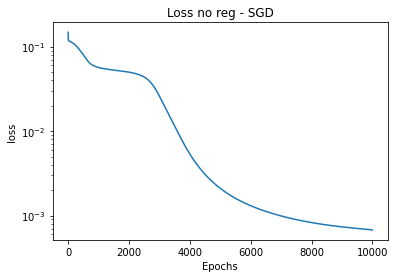

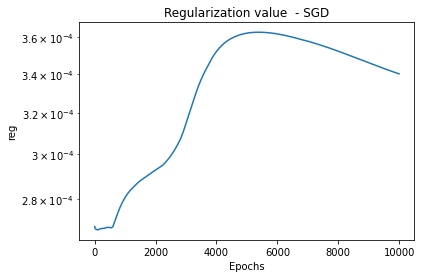

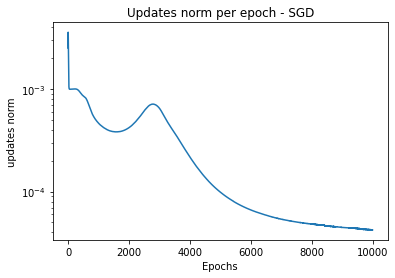

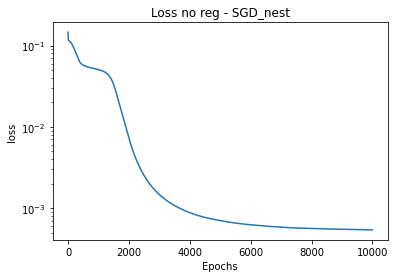

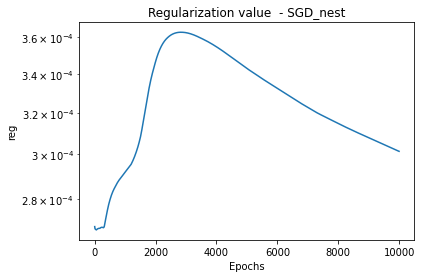

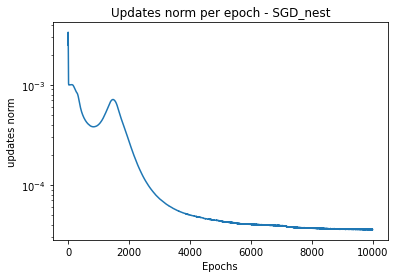

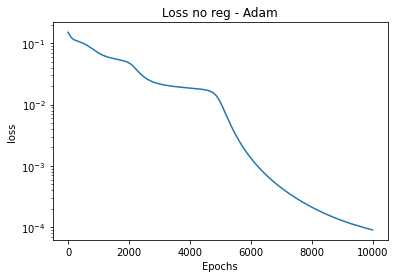

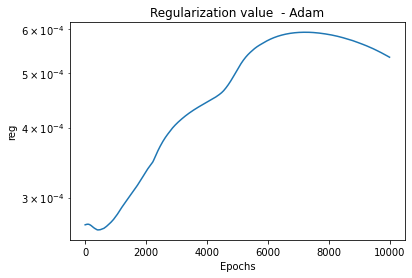

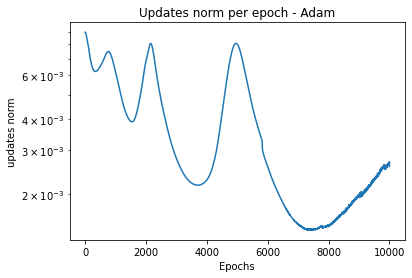

In [6]:
for net, model in zip([net_SGD, net_SGD_nest, net_Adam], ["SGD", "SGD_nest", "Adam"]):
    plotData(net.loss_noreg, 'loss', f"Loss no reg - {model}")
    plotData(net.reg, 'reg', f'Regularization value  - {model}')
    updates = net.opti.updates_norm
    updates_per_epoch = np.average((np.array(updates)).reshape(-1, int(len(updates)/len(net.train_loss))), axis=1)
    plotData(updates_per_epoch, 'updates norm', f'Updates norm per epoch - {model}')

#### Model performances

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


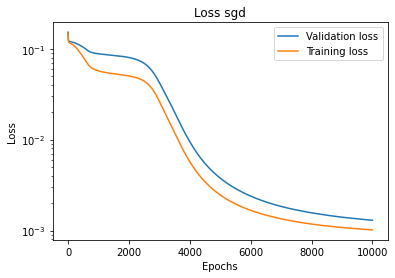

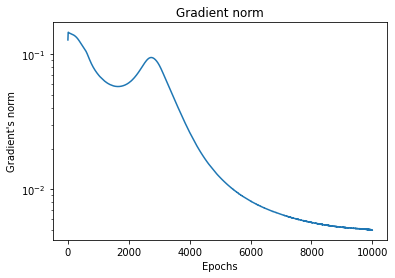

ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.29692e-03, 1.01545e-03 | Score:     1, 1    
ended in: 21690.622, avg per ep: 2.1690622
total update: 19058.000999999917, avg updt: 0.1588166749999993
total ff: 150000, total ff time: 4175.474999999989, avg ff: 0.02783649999999993
total bp: 130000, total bp time: 8513.269999999959, avg bp: 0.065486692307692
total ev: 10000, total ev time: 2417.199999999997, avg ev: 0.2417199999999997


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


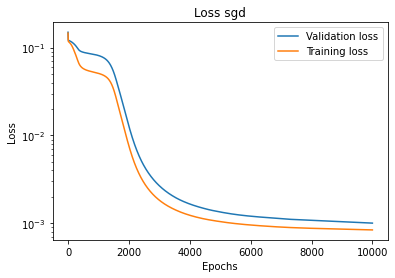

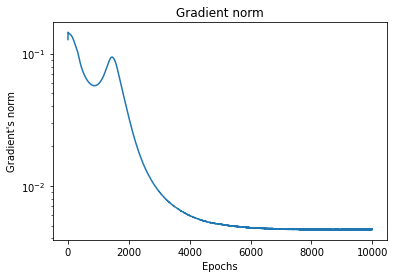

ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: True
Grad: 4.66666e-03 | Loss: 1.00545e-03, 8.41294e-04 | Score:     1, 1    
ended in: 24355.971, avg per ep: 2.4355971000000003
total update: 21678.773000000005, avg updt: 0.1806564416666667
total ff: 150000, total ff time: 4916.428000000006, avg ff: 0.03277618666666671
total bp: 130000, total bp time: 8859.377999999959, avg bp: 0.06814906153846122
total ev: 10000, total ev time: 2468.993000000005, avg ev: 0.2468993000000005


----- Adam -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.001, 'max_iter': 10000, 'solver': 'adam', 'tol': 1e-06}


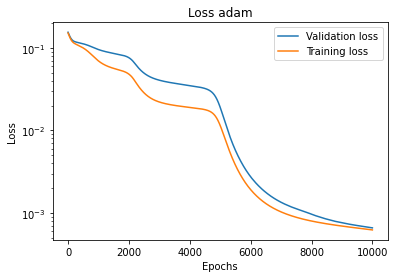

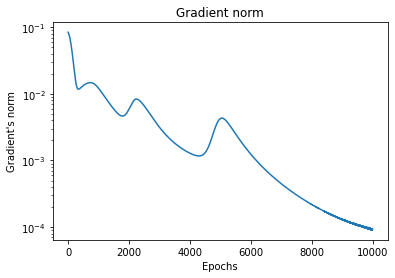

ep: 10000   | s: [3, 5] | b: 124 | e:0.001 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 9.39707e-05 | Loss: 6.61783e-04, 6.25015e-04 | Score:     1, 1    
ended in: 4860.7119999999995, avg per ep: 0.4860712
total update: 2464.251000000003, avg updt: 0.24642510000000029
total ff: 30000, total ff time: 1508.3320000000017, avg ff: 0.05027773333333339
total bp: 10000, total bp time: 974.9569999999995, avg bp: 0.09749569999999995
total ev: 10000, total ev time: 2300.1759999999995, avg ev: 0.23001759999999996




<Figure size 432x288 with 0 Axes>

In [8]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

#### Model comparison

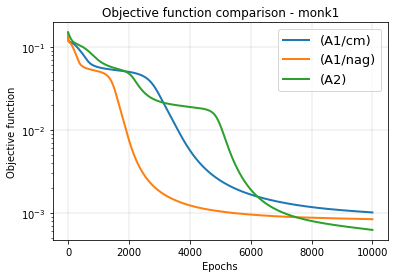

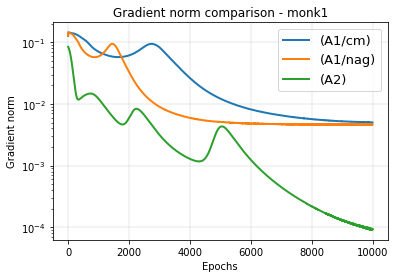

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=False)

## Monk2

In [ ]:
dataset = 'monk2'
epochs = 4000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk2'])
nn = NC
    
net_SGD = nn(**monk2['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk2['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk2['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NC(alpha=0, batch_size=10, hidden_layer_sizes=[3, 5], max_iter=4000,
   solver='adam', tol=1e-12)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


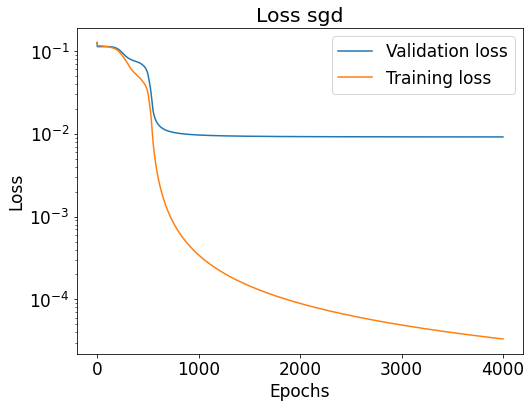

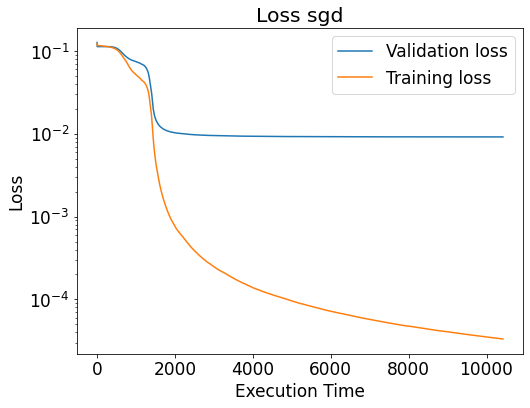

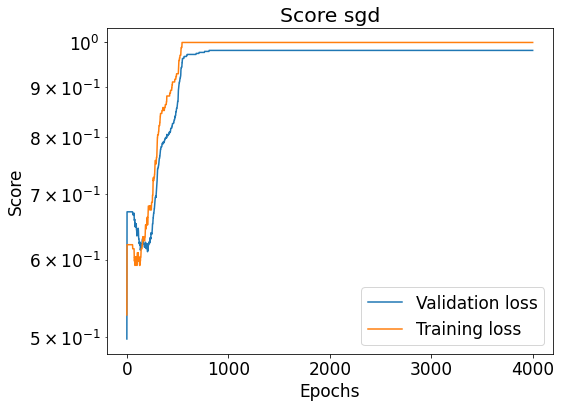

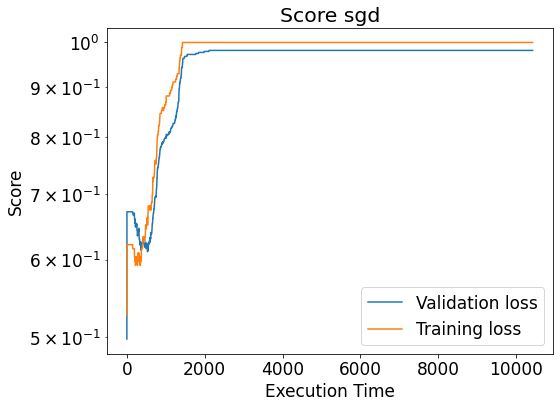

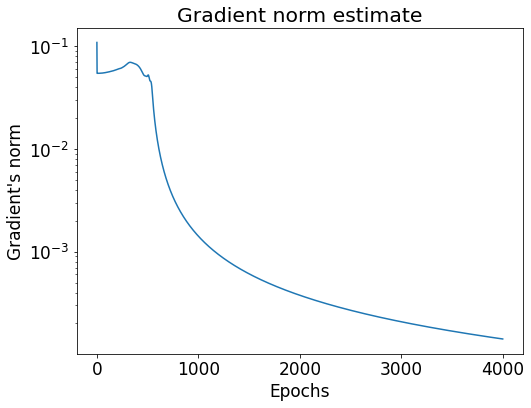

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.8 | nesterovs_momentum: False
Grad: 2.54636e-04 | Loss: 9.15942e-03, 3.32848e-05 | Score: 0.981, 1    
ended in: 10421.202, avg per ep: 2.6053005
total update: 9240.854000000027, avg updt: 2.310213500000007
total ff: 76000, total ff time: 2180.1909999989516, avg ff: 0.02868672368419673
total bp: 68000, total bp time: 4348.1269999998885, avg bp: 0.06394304411764543
total ev: 4000, total ev time: 1074.1010000000033, avg ev: 0.2685252500000008


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


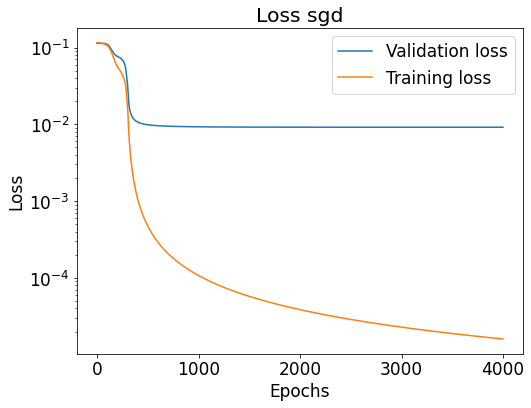

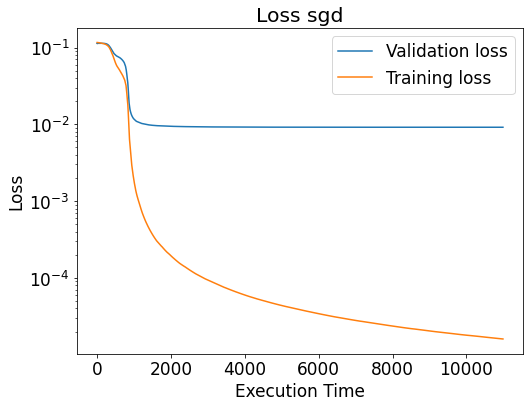

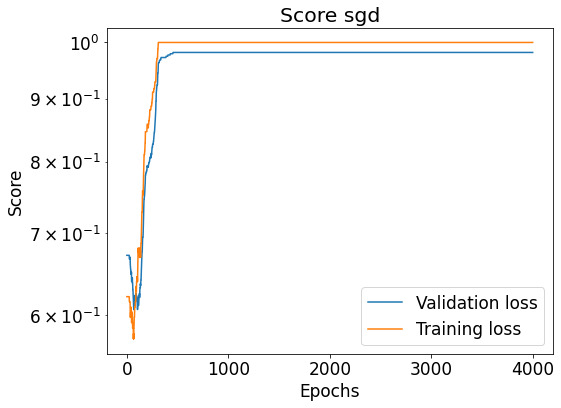

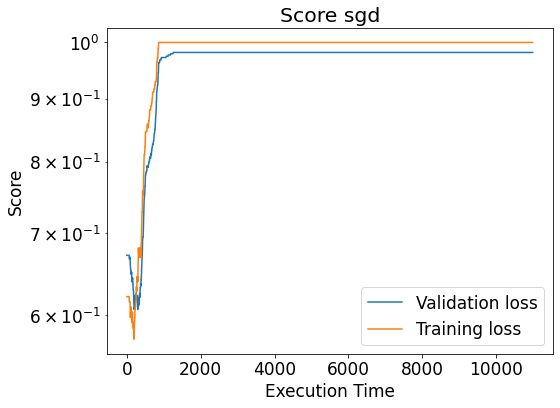

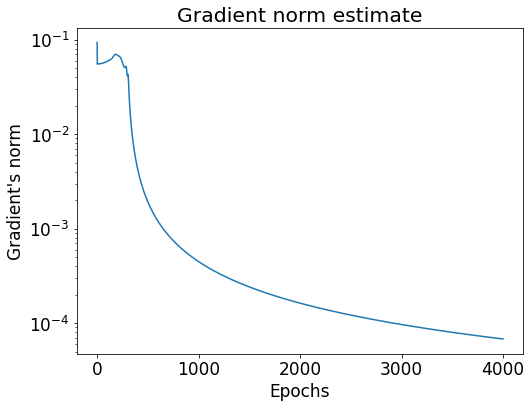

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.8 | nesterovs_momentum: True
Grad: 1.22827e-04 | Loss: 9.16134e-03, 1.93923e-05 | Score: 0.981, 1    
ended in: 10989.457, avg per ep: 2.74736425
total update: 9830.284999999982, avg updt: 2.4575712499999955
total ff: 76000, total ff time: 2158.2889999989134, avg ff: 0.028398539473669913
total bp: 68000, total bp time: 4257.242999999869, avg bp: 0.06260651470588044
total ev: 4000, total ev time: 1054.711000000004, avg ev: 0.26367775000000104


----- Adam -----
{'activation': 'logistic', 'alpha': 0, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 4000, 'solver': 'adam', 'tol': 1e-12}


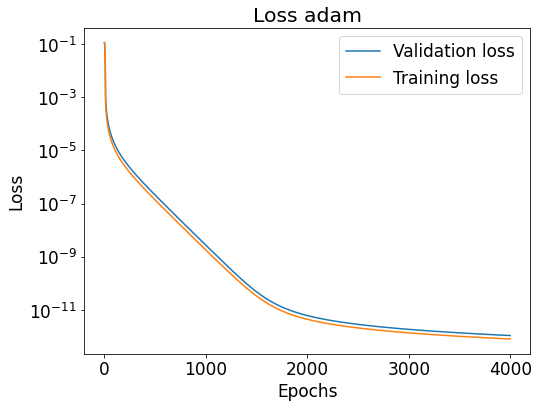

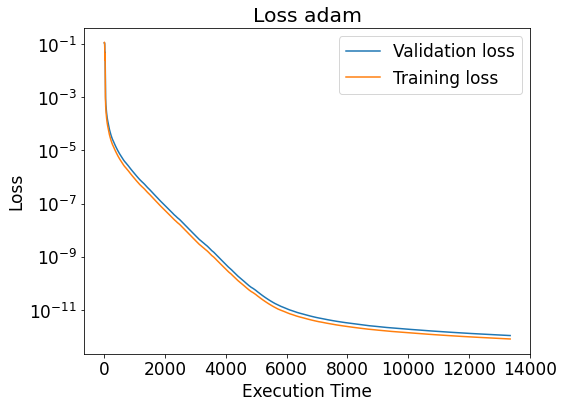

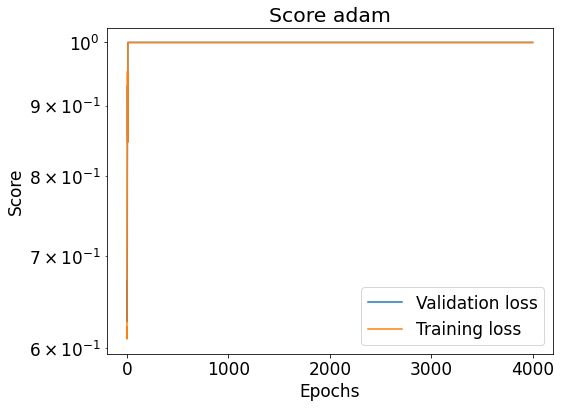

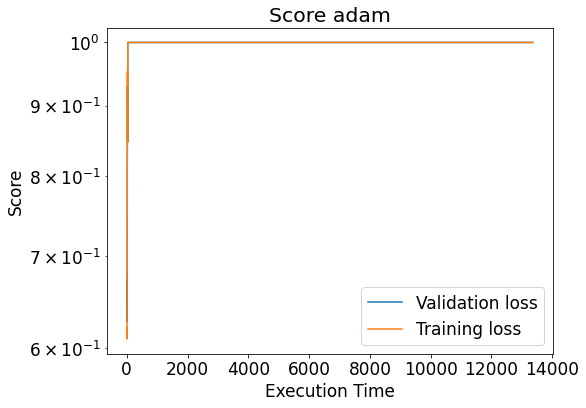

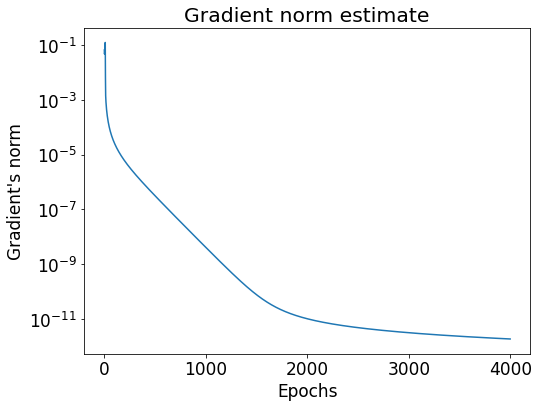

ep: 4000    | s: [3, 5] | b: 10 | e:  0.1 | alpha:    0 | m:  0.5 | nesterovs_momentum: False
Grad: 2.86899e-12 | Loss: 1.09534e-12, 8.13923e-13 | Score:     1, 1    
ended in: 13355.643, avg per ep: 3.33891075
total update: 12191.260000000033, avg updt: 3.0478150000000084
total ff: 76000, total ff time: 2213.3239999990533, avg ff: 0.02912268421051386
total bp: 68000, total bp time: 4442.326999998092, avg bp: 0.06532833823526606
total ev: 4000, total ev time: 1056.859000000001, avg ev: 0.2642147500000003




<Figure size 576x432 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

## Monk3

In [ ]:
dataset = 'monk3'
epochs = 4000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk3'])
nn = NC
    
net_SGD = nn(**monk3['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk3['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**monk3['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NC(alpha=0.1, batch_size=32, hidden_layer_sizes=[2, 3],
   learning_rate_init=0.005, max_iter=4000, solver='adam', tol=1e-12)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


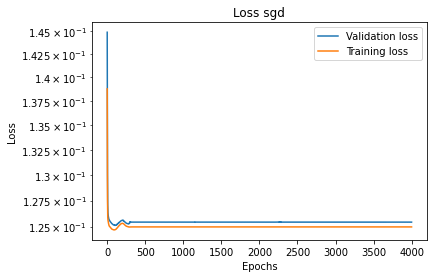

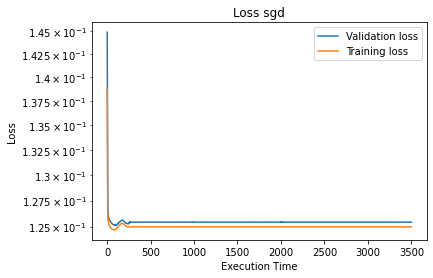

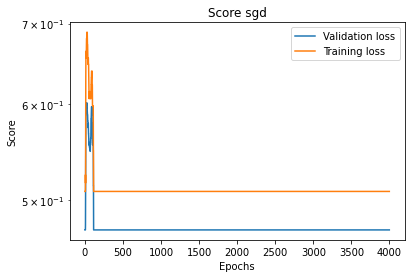

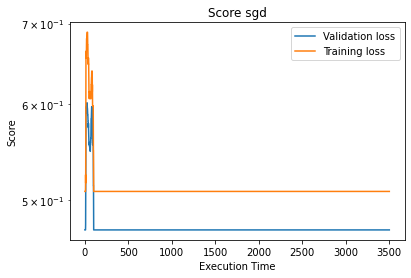

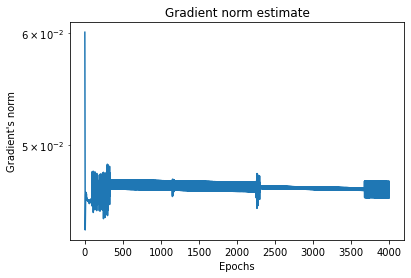

ep: 4000    | s: [2, 3] | b: 32 | e:  0.1 | alpha:  0.1 | m:  0.8 | nesterovs_momentum: False
Grad: 3.43946e-02 | Loss: 1.25120e-01, 1.24726e-01 | Score: 0.602, 0.689
ended in: 3502.275, avg per ep: 0.87556875
total update: 2437.958999999992, avg updt: 0.609489749999998
total ff: 24000, total ff time: 880.7590000000167, avg ff: 0.03669829166666736
total bp: 16000, total bp time: 1127.876999999976, avg bp: 0.0704923124999985
total ev: 4000, total ev time: 970.9770000000005, avg ev: 0.24274425000000013


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 4000, 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


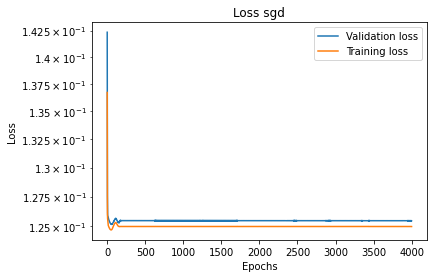

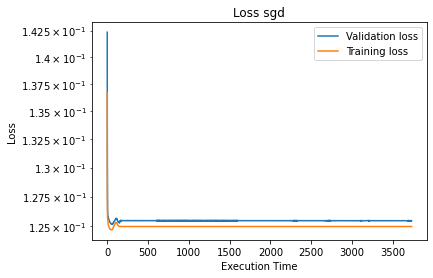

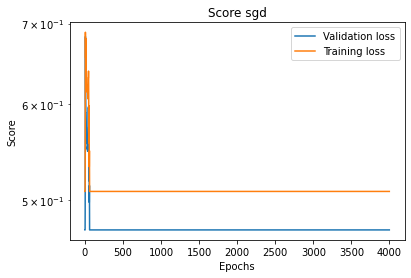

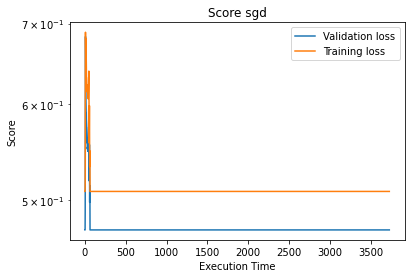

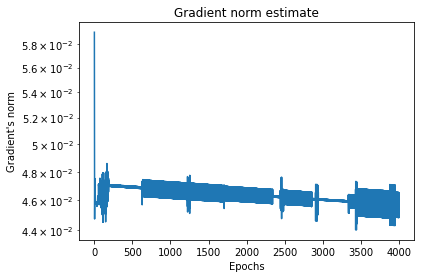

ep: 4000    | s: [2, 3] | b: 32 | e:  0.1 | alpha:  0.1 | m:  0.8 | nesterovs_momentum: True
Grad: 3.21481e-02 | Loss: 1.25157e-01, 1.24721e-01 | Score: 0.683, 0.689
ended in: 3729.698, avg per ep: 0.9324245
total update: 2659.165000000002, avg updt: 0.6647912500000005
total ff: 24000, total ff time: 886.3800000000023, avg ff: 0.0369325000000001
total bp: 16000, total bp time: 1145.5209999999195, avg bp: 0.07159506249999496
total ev: 4000, total ev time: 976.7329999999955, avg ev: 0.24418324999999888


----- Adam -----
{'activation': 'logistic', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.005, 'max_iter': 4000, 'solver': 'adam', 'tol': 1e-12}


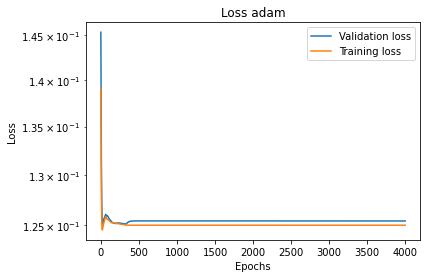

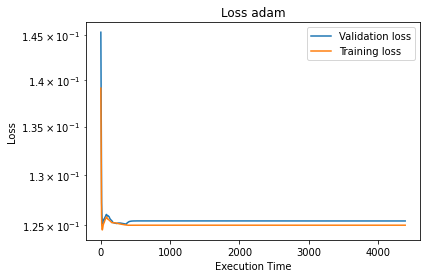

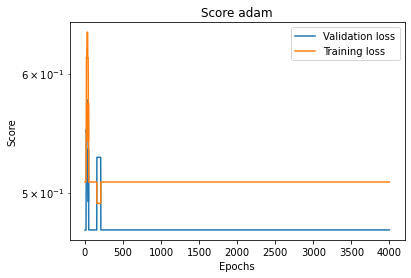

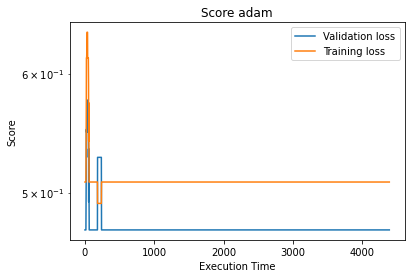

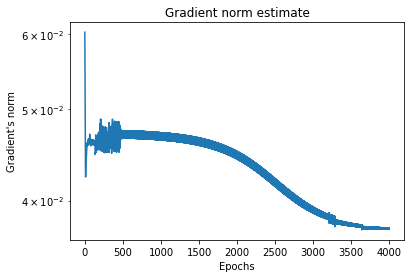

ep: 4000    | s: [2, 3] | b: 32 | e:0.005 | alpha:  0.1 | m:  0.5 | nesterovs_momentum: False
Grad: 2.99537e-02 | Loss: 1.25075e-01, 1.24985e-01 | Score: 0.576, 0.639
ended in: 4390.508, avg per ep: 1.097627
total update: 3294.982000000017, avg updt: 0.8237455000000042
total ff: 24000, total ff time: 913.1809999999274, avg ff: 0.03804920833333031
total bp: 16000, total bp time: 1175.0679999999456, avg bp: 0.0734417499999966
total ev: 4000, total ev time: 997.2409999999943, avg ev: 0.24931024999999857




<Figure size 432x288 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

## CUP

In [6]:
dataset = 'cup'

sgd_cm = params[dataset]['sgd'].copy()
sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
adam = params[dataset]['adam'].copy()

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
X_train, X_test, y_train, y_test = utils.load_CUP(datasets['cup'])
nn = NR
    
net_SGD = nn(**cup['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**cup['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_Adam = nn(**cup['Adam'])
net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

NR(alpha=0.3, batch_size=1033, hidden_layer_sizes=[5, 10],
   learning_rate_init=0.02, max_iter=10000, solver='adam', tol=1e-08)

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-08}


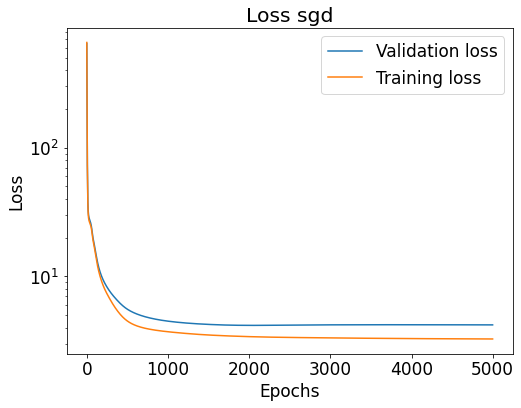

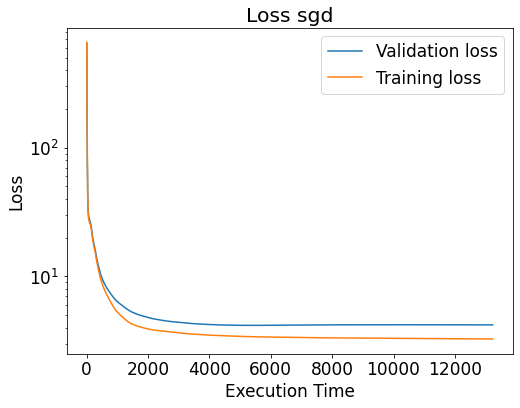

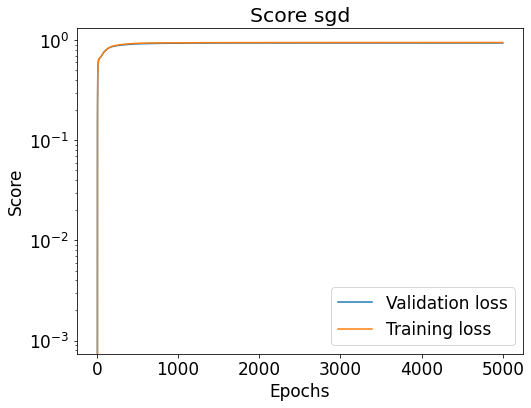

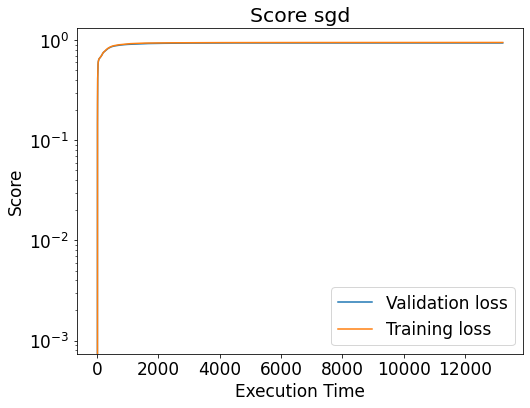

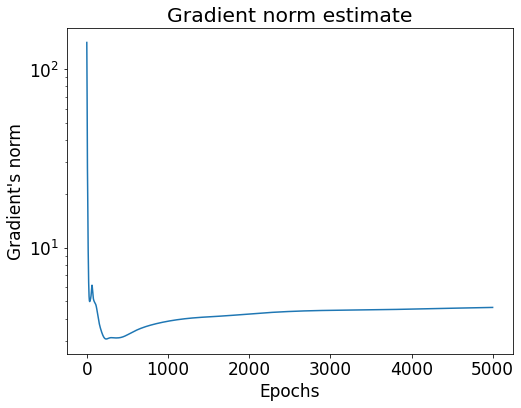

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: True
Grad: 7.07469e+00 | Loss: 4.16132e+00, 3.39729e+00 | Score: 0.939, 0.948
ended in: 13230.022, avg per ep: 2.6460044000000003
total update: 8778.969000000014, avg updt: 1.7557938000000028
total ff: 55000, total ff time: 3415.7770000007577, avg ff: 0.06210503636365014
total bp: 45000, total bp time: 4096.988999999987, avg bp: 0.09104419999999971
total ev: 5000, total ev time: 4309.9249999999965, avg ev: 0.8619849999999993


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-08}


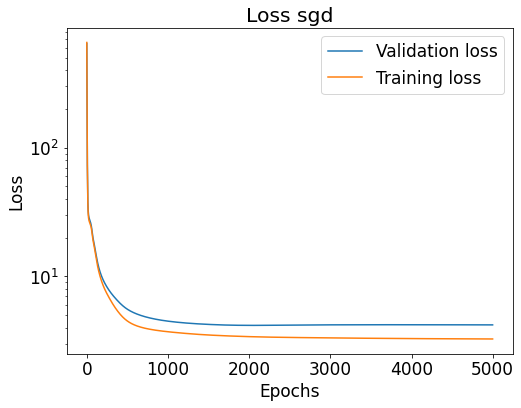

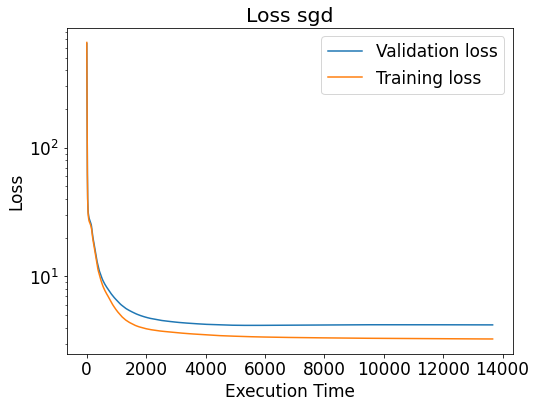

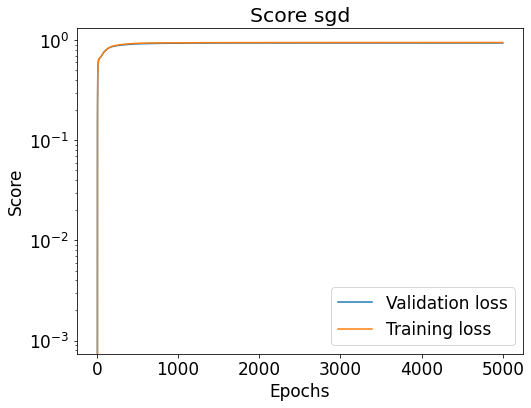

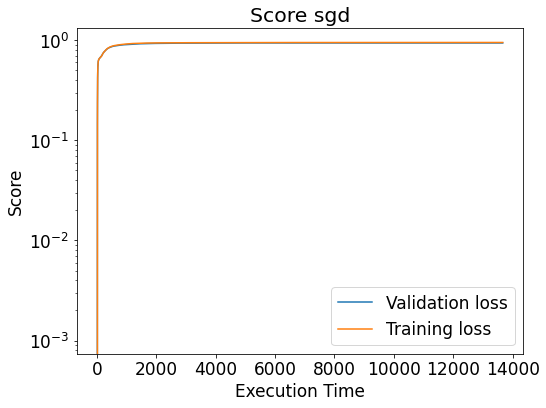

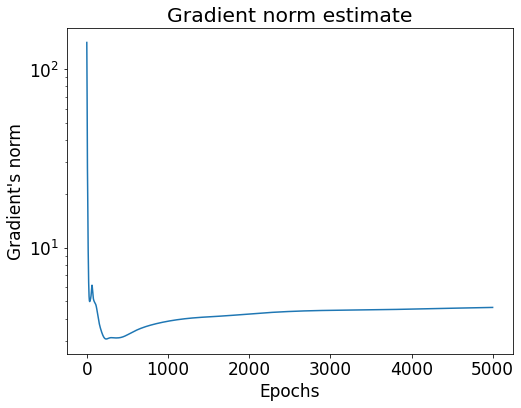

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: True
Grad: 7.07469e+00 | Loss: 4.16132e+00, 3.39729e+00 | Score: 0.939, 0.948
ended in: 13664.996, avg per ep: 2.7329991999999996
total update: 9022.920000000036, avg updt: 1.8045840000000073
total ff: 55000, total ff time: 3527.345000000563, avg ff: 0.06413354545455568
total bp: 45000, total bp time: 4202.846000000081, avg bp: 0.09339657777777959
total ev: 5000, total ev time: 4489.858000000003, avg ev: 0.8979716000000005


----- Adam -----
{'activation': 'logistic', 'alpha': 0.2, 'batch_size': 128, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.001, 'max_iter': 5000, 'solver': 'adam', 'tol': 1e-08}


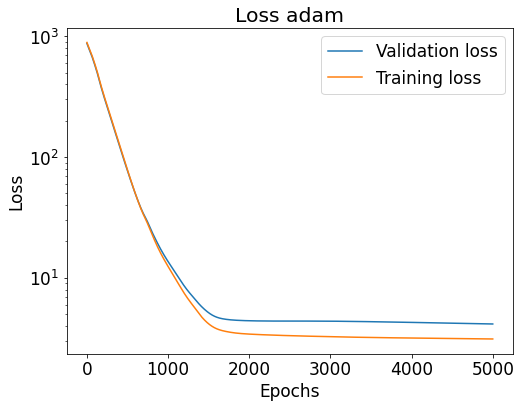

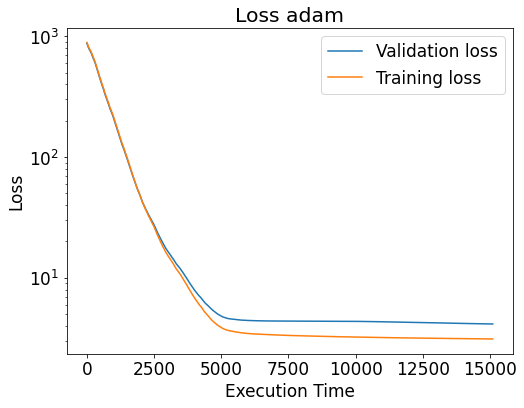

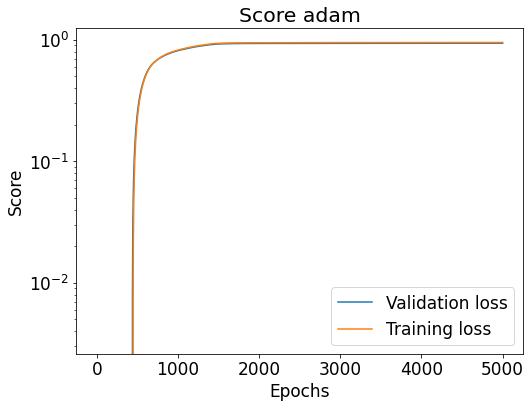

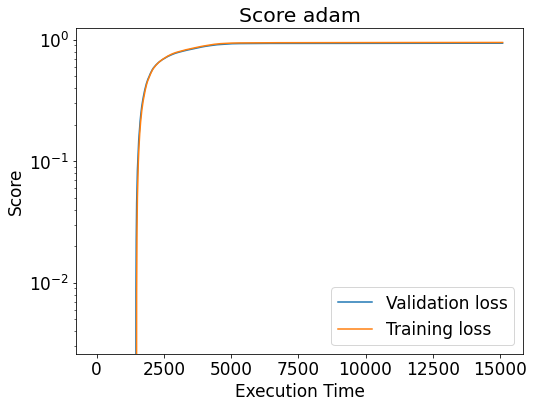

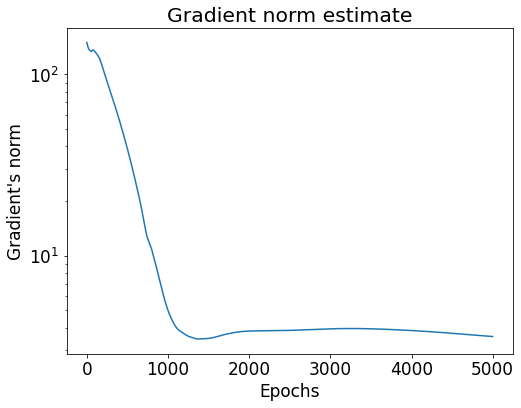

ep: 5000    | s: [5, 10] | b: 128 | e:0.001 | alpha:  0.2 | m:  0.5 | nesterovs_momentum: False
Grad: 5.70115e+00 | Loss: 4.14961e+00, 3.11830e+00 | Score: 0.939, 0.952
ended in: 15099.19, avg per ep: 3.019838
total update: 10433.73400000001, avg updt: 2.086746800000002
total ff: 55000, total ff time: 3530.243000000984, avg ff: 0.06418623636365425
total bp: 45000, total bp time: 4219.737000000212, avg bp: 0.09377193333333804
total ev: 5000, total ev time: 4509.113999999997, avg ev: 0.9018227999999994




<Figure size 576x432 with 0 Axes>

In [ ]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

# Report stats

In [4]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (8, 6)})

## Monk1

In [4]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:05<00:00, 1961.07it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.29692e-03, 1.01545e-03 | Score:     1, 1    
ended in: 21851.614, avg per ep: 2.1851614
total update: 19363.474000000002, avg updt: 0.16136228333333336
total ff: 150000, total ff time: 4168.967999999989, avg ff: 0.027793119999999925
total bp: 130000, total bp time: 8469.801999999956, avg bp: 0.06515232307692274
total ev: 10000, total ev time: 2280.082000000002, avg ev: 0.22800820000000022

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 

### Loss comparison

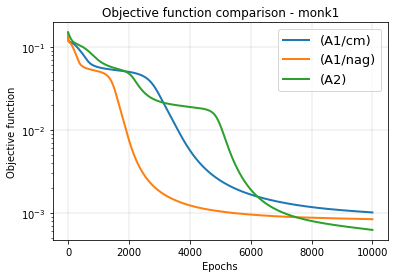

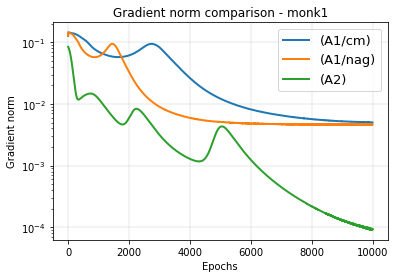

<Figure size 432x288 with 0 Axes>

In [5]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

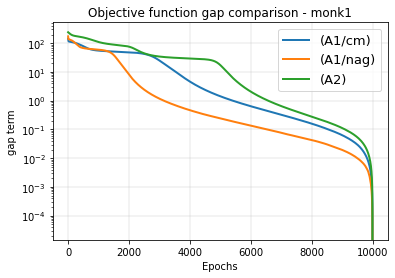

<Figure size 432x288 with 0 Axes>

In [6]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk2

In [7]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:05<00:00, 1993.29it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 6.95562e-04, 6.19129e-04 | Score:     1, 1    
ended in: 28313.731, avg per ep: 2.8313731
total update: 25539.185000000012, avg updt: 0.15961990625000008
total ff: 190000, total ff time: 5356.602999999994, avg ff: 0.02819264736842102
total bp: 170000, total bp time: 11158.853999999885, avg bp: 0.06564031764705815
total ev: 10000, total ev time: 2548.0559999999996, avg ev: 0.25480559999999997

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-

### Loss comparison

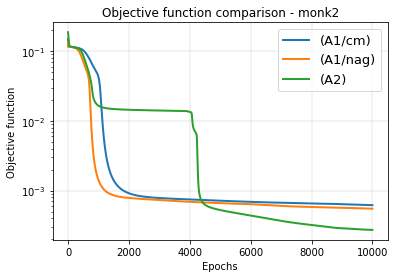

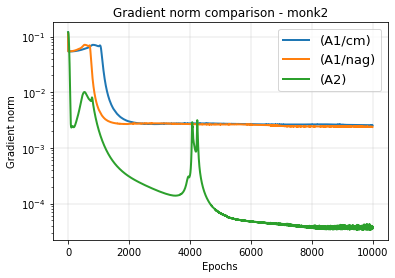

<Figure size 432x288 with 0 Axes>

In [8]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

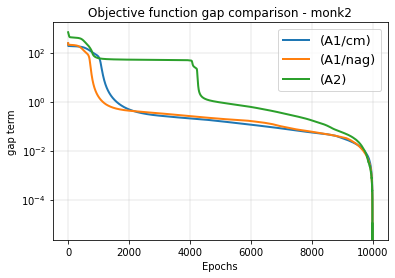

<Figure size 432x288 with 0 Axes>

In [9]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk3

In [10]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:04<00:00, 2289.47it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.20160e-02, 2.85011e-02 | Score: 0.972, 0.934
ended in: 3950.681, avg per ep: 0.3950681
total update: 1844.629000000001, avg updt: 0.1844629000000001
total ff: 30000, total ff time: 1200.3410000000003, avg ff: 0.04001136666666668
total bp: 10000, total bp time: 841.1750000000002, avg bp: 0.08411750000000001
total ev: 10000, total ev time: 2022.5729999999999, avg ev: 0.20225729999999997

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-

### Loss comparison

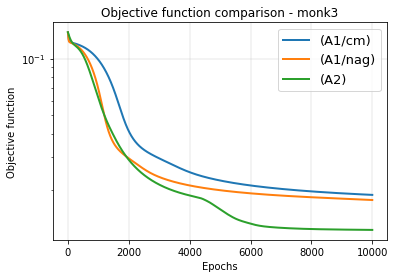

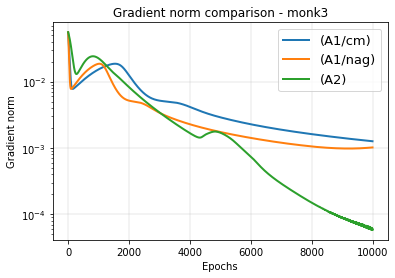

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

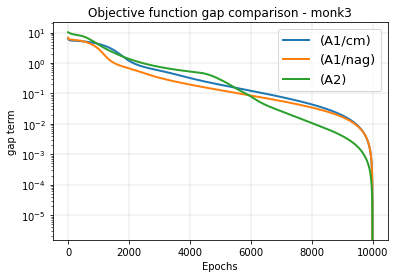

<Figure size 432x288 with 0 Axes>

In [12]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## CUP

In [13]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:13<00:00, 727.81it/s]


----- SGD -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False}
ep: 10000   | s: [5, 10] | b: 1066 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 4.20771e-02 | Loss: 4.16183e+00, 3.22065e+00 | Score: 0.939, 0.951
ended in: 13407.435, avg per ep: 1.3407434999999999
total update: 5422.9239999999745, avg updt: 0.5422923999999975
total ff: 30000, total ff time: 4374.763999999984, avg ff: 0.14582546666666613
total bp: 10000, total bp time: 2936.4429999999998, avg bp: 0.29364429999999997
total ev: 10000, total ev time: 7843.288999999943, avg ev: 0.7843288999999943

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False, 'nesterovs_momentum': Tr

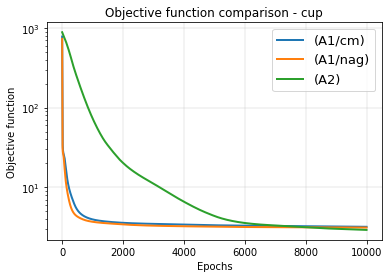

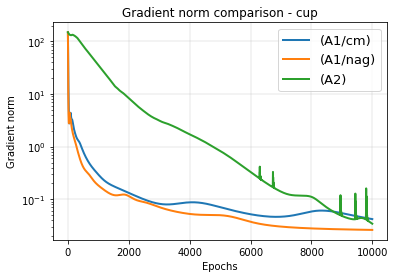

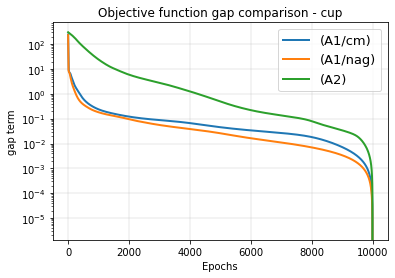

<Figure size 432x288 with 0 Axes>

In [14]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)